# Geospatial Machine Learning

There are several different platforms for implementing and experimenting with machine learning algorithms. For example, the **R** **caret** package allows for common syntax to be applied to execute a wide variety of algorithms. If you are interested in machine learning using R, please take a look at our Open-Source Spatial Analytics (R) course. 

In this course, we will explore [**scikit-learn**](https://scikit-learn.org/stable/index.html). This is a toolkit that expands the functionality of [**SciPy**](https://www.scipy.org/), a library for scientific computation with Python used extensively within mathematics, engineering, and the physical sciences in general. A  large numer of toolkits are avaialble for expanding SciPy. A full list can be found [here](http://scikits.appspot.com/scikits).

Scikit-learn specificially allows for:

* preprocessing data for use in predictive modeling
* training a variety of machine learning algorithms
* optimizing hyperparameters
* predicting to new data and assessing model performance
* visualizing models and results

Why do we care about machine learning as geospatial professionals and scientists? The primary reasons are that machine learning algorithms have been shown to be powerful tools for discovering patterns in data, mapping features, and modeling or predicting processes. They allow for a variety of prediction types including:

* **Categorical**: predict discrete categories, such as types of land cover or types of forests
* **Binary/Probabilistic**: differentiate two categories and/or predict the probabilty of a sample belonging to a certain class; for example, what is the likelihood that a location  might experience a landslide in the near future?
* **Continuous**: predict continuous measures, such as depth to water table or percent soil clay content; these are regression-type problems.

In this section, I will provide examples relating to a binary classification problem. Specifically, we will differentiate wetlands from uplands to produce an estimate of the probabilty of wetland occurence at locations on the landscape based on local topographic variables. 

After working through this module you will be able to:

1. prepare data for input into machine learning models.
2. optimize, train, and assess machine learning models.
3. compare feature spaces and different algorithms in regards to model performance.
4. apply results to raster-based spatial data to make spatial predictions.

We will not cover **deep learning** techniques in this course or the **Keras** library. We are working toward producing a second course focused on that topic. 

We have provided some lecture material along with this course that was created for our Open-Source Spatial Analytics (R) course that provides a conceptual background of machine learning applied to geospatial data. Although the code examples are based in R, this module is useful as a general background prior to working through this practical example. 

## Optimize, Train and Predict using Random Forest

As usual, we will begin by reading in the required libraries.

1. **Pandas**: read in our training and validation data tables and store them as DataFrames
2. **NumPy**: work with data arrays
3. **Matplotlib/Seaborn**: visualize data
4. **Rasterio**: read in raster data
5. **Pyspatialml**: apply machine learning models to predict to raster grids
6. **Scikit-learn**: implement machine learning in Python including data preprocessing, hyperparameter optimization, training, and assessment. 

In order to simplify the code, I am importing specific tools from scikit-learn. Here is a brief description of the specific tools.

1. **RandomForestClassifier()**: implementation of **random forest** (**RF**) algorithm for classification
2. **KNeighborsClassifier()**: implementation of ***k*-Nearest Neighbor** (***k*-NN**) algorithm for classification
3. **SVC**(): implementation of **support vector machines** (**SVM**) for classification
4. **confuion_matrix()**: return confusion matrix for model assessment
5. **classification_report()**: return several classification accuracy assessment metrics
6. **roc_curve()**: calculate **receiver operating caracteristics curve** for probabilistic assessment
7. **roc_auc_score()**: calculate **area under the ROC curve** (**AUC**)
8. **StandardScaler**: standardize predictor variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
import pyspatialml as pml
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

## Get the Data

I begin by reading in the **training** and **testing** data, which will be used to train the models and assess the performance. Sometimes the test set is refered to as the **validation** data. 

This is accomplished with **Pandas**, since the data are stored in CSV files. There are tools available in Python to extract training data using vector and raster data. However, I have found that this is generally easier in a GIS software tool, such as **QGIS** or **ArcGIS Pro**. So, I would recommend doing your data preparation in a GIS environment. For example, QGIS and ArcGIS Pro have tools available to extract raster values at point locations. 

The "class" field represents the category being predicted:

* "wet": example of a wetland
* "not": example of not a wetland

All of the predictor variables represent different measures that quantify the conditions of the local terrain surface.

1. "cost": distance from water bodies
2. "crv_arc": topographic curvature
3. "crv_plane": plan curvature
4. "crv_pro": profile curvature
5. "ctmi": compound topographic moisture index (CTMI)
6. "diss_5": terrain dissection (11 x 11 window)
7. "diss_10": terrain dissection (21 x 21 window)
8. "diss_20": terrain dissection (41 x 41 window)
9. "diss_25": terrain dissection (51 x 51 window)
10. "diss_a": terrain dissection average
11. "rough_5": terrain roughness (11 x 11 window)
12. "rough_10": terrain roughness (21 x 21 window)
13. "rough_20": terrain roughness (41 x 41 window)
14. "rough_25": terrain Roughness (51 x 51 window)
15. "rough_a": terrain roughness average
16. "slp_d": topographic slope in degrees
17. "sp_5": slope position (11 x 11 window)
18. "sp_10": slope position (21 x 21 window)
19. "sp_20": slope position (41 x 41 window)
20. "sp_25" slope position (51 x 51 window)
21. "sp_a": slope position average

It is common for examples to be provided as a single table. This will require the user to randomly split the data into training and testing sets. This can be accomlished using **model_selection.train_test_split()**. This function also allows for **stratified random sampling** based on a categorical variable. 

In [2]:
train = pd.read_csv('C:/Users/amaxwel6/random_forests/random_forests/training.csv')
test = pd.read_csv('C:/Users/amaxwel6/random_forests/random_forests/validation.csv')

In [3]:
print(train.head())

  class        cost     ctmi   crv_arc  crv_plane   crv_pro   diss_10  \
0   not  404.444000  9.72181 -0.376308  -0.270172  0.106136  0.596801   
1   not   19.365499  7.81020 -0.501769  -0.095858  0.405911  0.127337   
2   not  907.374023  5.83340  1.889750   0.630867 -1.258890  0.882726   
3   not  407.984985  6.05410  0.668900   0.152399 -0.516501  0.490594   
4   not  360.717987  6.85992 -0.878002  -0.237463  0.640539  0.421594   

    diss_20   diss_25    diss_5  ...  rough_25   rough_5  rough_a    slp_d  \
0  0.423932  0.390846  0.559673  ...   3.54012  1.430060  2.59963  4.11556   
1  0.070422  0.067852  0.150943  ...   3.12002  0.944582  2.02356  2.78634   
2  0.776313  0.746689  0.974049  ...   2.67275  1.538140  2.21755  5.02015   
3  0.504769  0.486941  0.592066  ...   3.29430  1.741610  2.53107  8.01975   
4  0.338215  0.330672  0.464568  ...   3.46882  1.948190  2.76768  8.94219   

      sp_10     sp_20     sp_25      sp_5      sp_a       dem_m  
0  0.823059  0.356201  -0.

In [4]:
print(test.head())

  class      cost      ctmi   crv_arc  crv_plane   crv_pro   diss_10  \
0   wet  0.000000  19.30950 -0.041820     0.0000  0.041820  0.070967   
1   wet  0.000000   9.93015 -0.961718     0.0000  0.961718  0.091834   
2   wet  0.656767  11.06300 -0.041820     0.0000  0.041820  0.580664   
3   wet  0.171550  12.10270  0.000000     0.0000  0.000000  0.288487   
4   wet  0.000000   9.09360 -0.209177    -0.0295  0.179677  0.159990   

    diss_20   diss_25    diss_5  ...  rough_25   rough_5   rough_a     slp_d  \
0  0.049314  0.042373  0.069436  ...   2.75714  1.060430  1.932930  0.114367   
1  0.054215  0.044775  0.072723  ...   2.20201  1.240590  1.796470  0.836766   
2  0.128384  0.117649  0.500000  ...   1.22992  0.318957  0.740689  0.053913   
3  0.084509  0.047502  0.000000  ...   1.48042  0.397072  0.863066  0.038122   
4  0.049411  0.048077  0.199988  ...   1.99719  0.556684  1.194620  1.158880   

      sp_10     sp_20    sp_25      sp_5      sp_a       dem_m  
0 -2.442140 -6.259220

Next, I separate out the dependent variable ("class") from the predictor variables to ceate a "train_y" object. To separate out the predictor variables, I drop the "class" column. I also drop 'dem_m", which represents the elevation and will not be used as a predictor variable. This process is then repeated for the test data. 

In [5]:
train_y = train['class']
train_x = train.drop(columns=['class', 'dem_m'])
test_y = test['class']
test_x = test.drop(columns=['class', 'dem_m'])
print(train_y.head())
print(train_x.head())

0    not
1    not
2    not
3    not
4    not
Name: class, dtype: object
         cost     ctmi   crv_arc  crv_plane   crv_pro   diss_10   diss_20  \
0  404.444000  9.72181 -0.376308  -0.270172  0.106136  0.596801  0.423932   
1   19.365499  7.81020 -0.501769  -0.095858  0.405911  0.127337  0.070422   
2  907.374023  5.83340  1.889750   0.630867 -1.258890  0.882726  0.776313   
3  407.984985  6.05410  0.668900   0.152399 -0.516501  0.490594  0.504769   
4  360.717987  6.85992 -0.878002  -0.237463  0.640539  0.421594  0.338215   

    diss_25    diss_5    diss_a  ...  rough_20  rough_25   rough_5  rough_a  \
0  0.390846  0.559673  0.492813  ...   3.21397   3.54012  1.430060  2.59963   
1  0.067852  0.150943  0.104138  ...   2.61464   3.12002  0.944582  2.02356   
2  0.746689  0.974049  0.844944  ...   2.59621   2.67275  1.538140  2.21755   
3  0.486941  0.592066  0.518593  ...   2.88848   3.29430  1.741610  2.53107   
4  0.330672  0.464568  0.388762  ...   3.20197   3.46882  1.948190  2.

Machine learning algorithms commonly have user-defined parameters that are not learned by the model and must be set by the user. These are known as **hyperparamters**. Default options are provided, but it is generally possible to improve the model performance by selecting these parameters.

How do you know what values to use? In order to select parameters, it is nessary to test a variety of combinations. In this example, I am using a **grid search** and ***k*-fold cross validation** to assess the model performance using all possible combinations of a set of provided values for different hyperparameters. 

This requires me to:

1. Create a **dictionary** with the parameter names and the values to test, provided as a **list**.
2. Initiate a model, RF in this case.
3. Define the grid search parameters; here I am specifically using 5-fold cross validation. 

If you decide to execute this code, not that it may take some time as a large number of models have to be generated and assessed. 

In [6]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

Now, I perform the grid search. A total of 1,440 models are fitted and evaluated using cross validation. 

In [7]:
# Fit the grid search to the data
grid_search.fit(train_x, train_y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  4.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

Once the grid search is complete, I obtain the list of selected, optimal parameters from the parameters that were tested. I then make a copy of the model that used the selected parameters and apply it to predict the test data. When using the model to make a prediction, you only have to provide the predictor variables, "test_x" in this case. 

In [8]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [9]:
rf_mod = grid_search.best_estimator_
print(rf_mod)
rfc_pred = rf_mod.predict(test_x)

RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=1000)


Once predications are made to the new, withheld test data, assessment metrics can be generated by comparing the predictions to the actual or corrrect classifications. 

First, I generate a **confusion matrix**. Of the 2,000 points, only 77 were misclassified, suggesting strong model perforamance. Next, I generate a variety of assessment metrics using **classification_report()**, including **precision**, **recall**, and the **F1 score**.

If you run this code, you may get a slightly different answer. This is because there is some randomness in the model. To ensure reproduceablility, you can set a **random seed**.

In [10]:
print(confusion_matrix(test_y,rfc_pred))

[[942  58]
 [ 18 982]]


In [11]:
print(classification_report(test_y, rfc_pred))

              precision    recall  f1-score   support

         not       0.98      0.94      0.96      1000
         wet       0.94      0.98      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In order to assess the model using ROC and AUC, we will need to obtain the predicted class probabilities as opposed to the "hard" or binary classification. This can be accomplished using **predict_proba()**. This will result in a prediction for both classes ("not" and "wet") that sum to 1. Larger probabilities for the "wet" class indicate that the algorithm predicted that that site was likely to be a wetland based on its local topographic characteristics. 

In [12]:
rfc_prob = rf_mod.predict_proba(test_x)

An ROC curve is easiest to calculate when the positive class is coded as 1 and the absence or negative class is coded as 0. So, I create a new verison of "test_y" where "wet" has been coded to 1 and "not" has been coded to zero. This is accomplished using **list comprehension**.

In the last line of code, I calculate the AUC score using the probabilities from the second column (index 1). This is because we are interested in the probabilities for the positive class. 

A large AUC of 0.99 is obtained, suggesting strong performance. 

In [13]:
test_y2 = test_y.to_numpy()
my_dict = {"not":0, "wet":1}
test_y3 = np.asarray([my_dict[zi] for zi in test_y2])
roc_auc_score(test_y3, rfc_prob[:,1])

0.991256

Next, I calculate the ROC curve and plot the result using Matplotlib. The **roc_curve()** function produces multiple outputs at once using **tuple unpacking**.

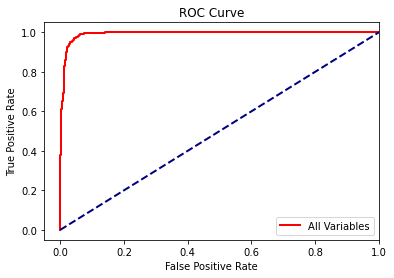

In [15]:
fpr, tpr, _ = roc_curve(test_y3,  rfc_prob[:, 1])
plt.plot(fpr,tpr, color ='red', lw=2, label="All Variables")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Compare Feature Space

Now that we have worked through the entire process, I will provide some examples of comparing different models and different algorithms. In this example specifically, we will assess three different models that use different sets of local terrain features:

1. All terrain variables
2. Just topographic slope
3. Topographic slope + Slope position

First, I create the data subsets. When creating the data for just slope, I have to explicitly define the output as a DataFrame. Since only one column is present, the default is to output a **Series**. 

In [27]:
train_y = train['class']
train_x = train.drop(columns=['class', 'dem_m'])
test_y = test['class']
test_x = test.drop(columns=['class', 'dem_m'])

train_x_slp = pd.DataFrame(train['slp_d'])
test_x_slp = pd.DataFrame(test['slp_d'])

train_x_slp_sp = train[['slp_d', 'sp_a']]
test_x_slp_sp = test[['slp_d', 'sp_a']]

Next, I fit the three different models. I am not optimizing the hyperparameters for the sake of time. However, for a more robust experiment, each model should be optimized separately. 

In [28]:
rf1 = RandomForestClassifier(n_estimators=200)
rf_model1 = rf1.fit(train_x, train_y)
rf2 = RandomForestClassifier(n_estimators=200)
rf_model2 = rf2.fit(train_x_slp, train_y)
rf3 = RandomForestClassifier(n_estimators=200)
rf_model3 = rf3.fit(train_x_slp_sp, train_y)

Once the models are fitted, I then use them to predict the test data and assess using the classification metrics. The model with all the terrain parameters performs best, followed by slope + slope postion. The slope  model was the poorest; however, precision, recall, and the F1 score are all still above 0.85, suggesting that topographic slope is an important predictor of wetland occurence. However, the inclusion of additional predictor variables does improve performance; even if we only include slope position, the overall accuracy increases by 6%.

In [29]:
pred_model1= rf_model1.predict(test_x)
pred_model2 = rf_model2.predict(test_x_slp)
pred_model3 = rf_model3.predict(test_x_slp_sp)
print(classification_report(test_y, pred_model1))
print(classification_report(test_y, pred_model2))
print(classification_report(test_y, pred_model3))

              precision    recall  f1-score   support

         not       0.98      0.95      0.96      1000
         wet       0.95      0.98      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

              precision    recall  f1-score   support

         not       0.87      0.86      0.86      1000
         wet       0.86      0.87      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

              precision    recall  f1-score   support

         not       0.92      0.92      0.92      1000
         wet       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In order to further explore and compare the results, I calculate the AUC measures and the ROC curves. Using Matplotlib, I plot all the curves in the same graph space for comparison. 

Again, these metrics suggest that all variables provides the strongest performance followed by slope + slope position. 

In [30]:
test_y2 = test_y.to_numpy()
my_dict = {"not":0, "wet":1}
test_y3 = np.asarray([my_dict[zi] for zi in test_y2])

rfc_prob1 = rf_model1.predict_proba(test_x)
rfc_prob2 = rf_model2.predict_proba(test_x_slp)
rfc_prob3 = rf_model3.predict_proba(test_x_slp_sp)

print("All Variables: " + str(roc_auc_score(test_y3, rfc_prob1[:,1])))
print("Just Slope: " + str(roc_auc_score(test_y3, rfc_prob2[:,1])))
print("Slope + Slope Position: " + str(roc_auc_score(test_y3, rfc_prob3[:,1])))                       

All Variables: 0.9903839999999999
Just Slope: 0.9282385
Slope + Slope Position: 0.967464


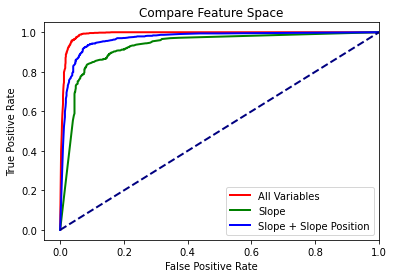

In [32]:
fpr1, tpr1, _ = roc_curve(test_y3,  rfc_prob1[:, 1])
fpr2, tpr2, _ = roc_curve(test_y3,  rfc_prob2[:, 1])
fpr3, tpr3, _ = roc_curve(test_y3,  rfc_prob3[:, 1])
plt.plot(fpr1,tpr1, color ='red', lw=2, label="All Variables")
plt.plot(fpr2,tpr2, color ='green', lw=2, label="Slope")
plt.plot(fpr3,tpr3, color ='blue', lw=2, label="Slope + Slope Position")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Compare Feature Space')
plt.legend(loc="lower right")
plt.show()

## Compare Algorithms

We will now compare three different machine learning algorithms: RF, *k*-NN, and SVM. Specifically, we will only use the topographic slope and slope position predictor variables. 

In this first set of code I am preparing the training and testng data. RF is not generally sensitive or impacted by the predictor variable scale, which is also true for other tree-based models, such as **single decision trees** and **boosted decision trees**. However, SVM, a kernel-based method, and *k*-NN are impacted. So, it is necessary to rescale the data prior to using them in the prediction. 

This is accomplished using **StandardScaler()**. This is fit to the training data, and the results are used to rescale both the testing and training data. This is so that the model is not biased by seeing a representation of the testing data prior to training and so that the data sets share a common transformation. 

All subsequent modeling is conducted on the rescaled data. 

In [33]:
train_x_sub = train[['slp_d', 'sp_a']]
test_x_sub = test[['slp_d', 'sp_a']]

scaler = StandardScaler()
scale_fit = scaler.fit(train_x_sub)
train_x2 = pd.DataFrame(scale_fit.transform(train_x_sub))
train_x2.columns = ['slp_d', 'sp_a']
test_x2 = pd.DataFrame(scale_fit.transform(test_x_sub))
test_x2.columns = ['slp_d', 'sp_a']
print(train_x_sub.head())
print(train_x2.head())

     slp_d      sp_a
0  4.11556  0.186066
1  2.78634 -4.649020
2  5.02015  4.618710
3  8.01975 -0.955795
4  8.94219 -5.929780
      slp_d      sp_a
0 -0.520301  0.237190
1 -0.667147 -0.580154
2 -0.420365  0.986504
3 -0.088983  0.044165
4  0.012924 -0.796660


Once the data are prepared, I next initiate the three models then train them using the rescaled training data. Again, the models should be optimized for a more rigorous experiment. However, I am not doing so here to save time. 

In [34]:
rf_comp =  RandomForestClassifier(n_estimators=200)
knn_comp = KNeighborsClassifier(n_neighbors=7)
svm_comp =  SVC()

rf_compM = rf_comp.fit(train_x2, train_y)
knn_compM = knn_comp.fit(train_x2, train_y)
svm_compM = rf_comp.fit(train_x2, train_y)

I then predcict to the rescaled test data using all three models and compare them using classification metrics (accuracy, precision, recall, and the F1 score) and ROC curves. 

The results suggest that all three models have similar performance for this specific problem. 

In [35]:
pred_rf_comp= rf_compM.predict(test_x2)
pred_knn_comp = knn_compM.predict(test_x2)
pred_svm_comp = svm_compM.predict(test_x2)
print(classification_report(test_y, pred_rf_comp))
print(classification_report(test_y, pred_knn_comp))
print(classification_report(test_y, pred_svm_comp))

              precision    recall  f1-score   support

         not       0.92      0.93      0.92      1000
         wet       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

              precision    recall  f1-score   support

         not       0.93      0.91      0.92      1000
         wet       0.91      0.93      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

              precision    recall  f1-score   support

         not       0.92      0.93      0.92      1000
         wet       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [36]:
test_y2 = test_y.to_numpy()
my_dict = {"not":0, "wet":1}
test_y3 = np.asarray([my_dict[zi] for zi in test_y2])

rf_comp_prob = rf_compM.predict_proba(test_x2)
knn_comp_prob = knn_compM.predict_proba(test_x2)
svm_comp_prob = svm_compM.predict_proba(test_x2)

print("RF: " + str(roc_auc_score(test_y3, rf_comp_prob[:,1])))
print("K-NN: " + str(roc_auc_score(test_y3, knn_comp_prob[:,1])))
print("SVM: " + str(roc_auc_score(test_y3, svm_comp_prob[:,1])))   

RF: 0.967562
K-NN: 0.9650399999999999
SVM: 0.967562


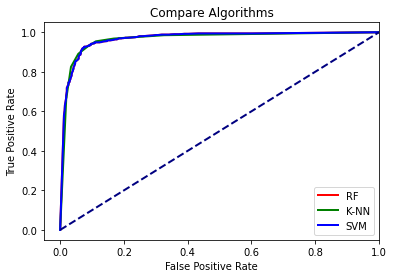

In [37]:
fpr1, tpr1, _ = roc_curve(test_y3,  rf_comp_prob[:, 1])
fpr2, tpr2, _ = roc_curve(test_y3,  knn_comp_prob[:, 1])
fpr3, tpr3, _ = roc_curve(test_y3,  svm_comp_prob[:, 1])
plt.plot(fpr1,tpr1, color ='red', lw=2, label="RF")
plt.plot(fpr2,tpr2, color ='green', lw=2, label="K-NN")
plt.plot(fpr3,tpr3, color ='blue', lw=2, label="SVM")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Compare Algorithms')
plt.legend(loc="lower right")
plt.show()

## Predict to Raster Data

Since this classes focuses on geospatial data analysis, it is important to discuss how trained models can be applied to geospatial data. Again, I recommend that you do your data preparation in your GIS software, such as making your training and testing data tables. However, you will need to appy the trained models to your spatial data in Python. 

There are sevreral ways to accomplish this. Here, I am relying on [**Pyspatialml**](https://github.com/stevenpawley/Pyspatialml). Currently, this is an experimental package that is only available on GitHub. 

Using the **Raster()** function from this package, I call in a grid stack of the predictor variables. I have generally found that it is easier to feed in the predictor variables as a single grid stack, which is prepared using GIS software, to avoid any issues with cell misalignment or different numbers of rows and columns. Python is generally not robust to dealing with these issues. 

I then use the *name* property to list the band names. Since the code needs to know which band cooresponds to which predictor variable from the training table, I have to rename the bands to match the table. This is accomplished using the Pyspatialml method **rename()**, which accepts a dictionary of current and new name pairs. This will require you to know which band coorespond to which predictor variable. So, keep this in mind when you are generating grid stacks. 

In [38]:
r_preds = pml.Raster("C:/Users/amaxwel6/random_forests/random_forests/predictors.img")
print(r_preds.names)
r_preds.rename({'predictors_1':"cost", 
               'predictors_2':"crv_arc", 
               'predictors_3':"crv_plane", 
               'predictors_4': "crv_pro", 
               'predictors_5':"ctmi", 
               'predictors_6':"diss_5", 
               'predictors_7':"diss_10", 
               'predictors_8':"diss_20", 
               'predictors_9':"diss_25", 
               'predictors_10':"diss_a", 
               'predictors_11':"rough_5", 
               'predictors_12':"rough_10", 
               'predictors_13':"rough_20", 
               'predictors_14':"rough_25", 
               'predictors_15':"rough_a", 
               'predictors_16':"slp_d", 
               'predictors_17':"sp_5", 
               'predictors_18':"sp_10", 
               'predictors_19':"sp_20", 
               'predictors_20':"sp_25", 
               'predictors_21':"sp_a"})
print(r_preds.names)

['predictors_1', 'predictors_2', 'predictors_3', 'predictors_4', 'predictors_5', 'predictors_6', 'predictors_7', 'predictors_8', 'predictors_9', 'predictors_10', 'predictors_11', 'predictors_12', 'predictors_13', 'predictors_14', 'predictors_15', 'predictors_16', 'predictors_17', 'predictors_18', 'predictors_19', 'predictors_20', 'predictors_21']
['cost', 'crv_arc', 'crv_plane', 'crv_pro', 'ctmi', 'diss_5', 'diss_10', 'diss_20', 'diss_25', 'diss_a', 'rough_5', 'rough_10', 'rough_20', 'rough_25', 'rough_a', 'slp_d', 'sp_5', 'sp_10', 'sp_20', 'sp_25', 'sp_a']


Once the raster stack is prepared, I predict the probability at each grid cell using an RF model trained using all the predictor variables. Since I want a probabilistic output, I use **predict_prob()** as opposed to **predict()**.

Once the result is obtained, I write it to disk. 

In [39]:
result = r_preds.predict_proba(estimator=rf_mod)

In [40]:
result.write("D:/scratch/wet_pred.tif")

Lastly, I read the file back in with Rasterio and plot the result using Matplotlib. 

This prediction is specfically for palustrine forested wetlands, so it would be good to mask the results so that predictions are only made in forested extents. This can be accomplished using GIS software and overlay with a forest extent data set. 

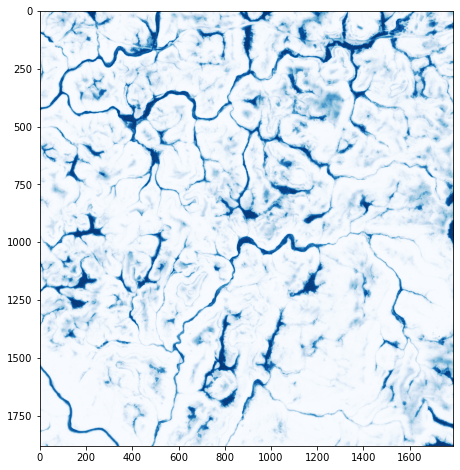

In [41]:
m_result = rio.open("D:/scratch/wet_pred.tif")
m_result_arr = m_result.read(2)
plt.rcParams['figure.figsize'] = [10, 8]
plt.imshow(m_result_arr, cmap="Blues", vmin=0, vmax=1)

## Concluding Remarks

My goal here was to provide a practical introduction to using scikit-learn for machine learing-based predictive modeling. You should now have a general understanding of how to prepare data, optimize algorithms, train models, and assess model performance. If you need to predict back to raster grids, I would suggest Pyspatialml, which is available on GitHub. 